In [51]:
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from typing import Dict
import matplotlib.pyplot as plt

import requests
import random
import warnings

import deepstack.core as ds

IP = "localhost"
PORT = 80


np.random.seed(6789)

Load metadata

In [2]:
metadata = pd.read_csv("../metadata/identity_CelebA.txt", delimiter = " ", header=0, names = ["photo", "ind"])
metadata.sample(3)

,photo,ind
193750,193752.jpg,9541
170863,170865.jpg,2324
66148,066150.jpg,1264


Check individuals with multiple photos

In [3]:
metadata["ind"].value_counts()

2820    35
3782    35
3227    35
3745    34
3699    34
        ..
8815     1
9770     1
2264     1
9075     1
3481     1
Name: ind, Length: 10177, dtype: int64

In [113]:
# Utility function that will be required for train and testing

def train_faces(faces_map, timeout = 10, api_key = "", verbose = 0): 
    """Train faces using the deepstack API. The Key is the name of the individual and the value list are the photos"""
    #First remove all the trained faces
    if (verbose == 0): 
        print("Deleting registered faces before benchmark")
    list_faces = requests.post(f"http://{IP}:{PORT}/v1/vision/face/list", timeout=timeout, data={"api_key": api_key}).json()
    for face in list_faces["faces"]: 
        requests.post(f"http://{IP}:{PORT}/v1/vision/face/delete", timeout = timeout, data={"userid":face, "api_key": api_key}).json()
    
    if (verbose == 0): 
        print("Finished deleting faces ... training")
    # Train each face individually
    trained_faces = []
    for name, images in faces_map.items():
        for file_path in images: 
            file_path = f'../img_data/img_align_celeba/{file_path}'
            response = register_face(name, file_path, timeout=timeout, api_key=api_key)
            if response == True: 
                trained_faces.append(name)
    
    if (verbose == 0): 
        print("Training completed")
    return trained_faces



def register_face(name, file_path, timeout = 10, api_key = ""):
    """
    Register a name to a file.
    """
    url = f"http://{IP}:{PORT}/v1/vision/face/register"
    try:
        with open(file_path,"rb") as image:
            response = requests.post(url, 
                                     files={"image":image.read()}, 
                                     data={"userid":name,
                                     "api_key": api_key})
            
        if response.status_code == 200 and response.json()['success'] == True:
            #print(f"Deepstack taught face {name} using file {file_path}")
            return True
        elif response.status_code == 200 and response.json()['success'] == False:
            error = response.json()['error']
            print(f"Deepstack error: {error}")
            return False

        else:
            print(response.json())
            return False

    except Exception as exc:
        print(exc)
        return False


def test_faces(test_map, min_confidence, timeout = 10, api_key=""): 
    """Test faces
    In the case where are multiple faces, it returns only the most correct prediction"""
    ds_api = ds.DeepstackFace(ip = IP, port = PORT, api_key=api_key, timeout=timeout, min_confidence=min_confidence)
    results = []
    for ind, images in test_map.items(): 
        for file_path in images:
            test_image = open(f'../img_data/img_align_celeba/{file_path}', "rb").read()
            result = ds_api.recognize(test_image)
            if result != []:
                #In case there are multiple results, the function only keeps the best one
                best_result = ["", "", 0, ""]
                for predictions in result: 
                    prediction = predictions['userid']
                    confidence = predictions['confidence']
                    if best_result[2] < confidence:  
                        best_result = [str(ind), str(prediction), confidence, file_path]
                results.append(best_result)
            else:
                results.append([str(ind), None, None, file_path])
    
    df = pd.DataFrame(results, columns=['ind', 'prediction', 'confidence', 'photo'])
    return df

def performance_metrics(df_all, actual_col, prediction_col, min_confidence = 0):
    df = df_all[df_all['confidence'] > min_confidence]
    predictions_ignored = 100* (df_all.shape[0] - df.shape[0]) / df_all.shape[0]
    y_true = df[actual_col].tolist()
    y_pred = df[prediction_col].tolist()
    
    warnings.filterwarnings('ignore', category=UserWarning) # Used due to pesky warning with the precision score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    warnings.filterwarnings('default')
    
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, "prediction_ignored" : predictions_ignored}
    
    return metrics



def output_metrics_table(performace: pd.DataFrame, min_conf: float, max_conf: float, step: float) -> pd.DataFrame:
    """
    Iterates over different confidence thresholds with a specified step size and outputs the metrics for each
    threshold in a table format.

    Args:
        performace (pd.Dataframe): A dataframe containing the performance metrics.
        min_conf (float): The minimum confidence threshold to start the iteration from.
        max_conf (float): The maximum confidence threshold to end the iteration at.
        step (float): The step size for the confidence threshold.
    Returns:
        pd.DataFrame: A pandas DataFrame containing the confidence threshold and corresponding precision,
        recall, f1, and accuracy metrics for each threshold, as well as the number of ignored predictions
    """
    metrics = ["Precision", "Recall", "F1 Score", "Accuracy", "prediction_ignored"]
    results = pd.DataFrame(columns=["Confidence Threshold"] + metrics)

    
    conf_range = [round(x, 2) for x in list(np.arange(min_conf, max_conf+step, step))]

    for conf in conf_range:
        perf_metrics = performance_metrics(performace, "ind", "prediction", min_confidence=conf)
        metric_values = [perf_metrics[metric] for metric in metrics]
        results = pd.concat([results, pd.DataFrame({"Confidence Threshold": conf, **dict(zip(metrics, metric_values))}, index=[0])])
    return results


Subset individuals with at least 20 photos

In [9]:
ind_counts = metadata['ind'].value_counts()

selected_inds = ind_counts[ind_counts >= 20].index

metadata_subset = metadata[metadata['ind'].isin(selected_inds)]

metadata_subset['ind'].value_counts()

#I have 6348 individuals to train

3782    35
2820    35
3227    35
3745    34
3699    34
        ..
379     20
332     20
6037    20
9676    20
3737    20
Name: ind, Length: 6348, dtype: int64

## Family benchmark 

Make a benchmark where 4-5 faces are registered. Each 4-5 faces is a "Family". 
Then test the faces using a) family photoes and b) new photos

In [30]:


def small_group_benchmark(metadata_subset, n_interations, n_individuals, n_photos_train, n_photos_test_family, n_photos_test_group): 
    """
    This function runs a benchmark on a small group of individuals, by testing the performance of a face recognition algorithm. The performance is evaluated by using two sets of test photos: 
    1. Test photos from the same individuals used for training 
    2. Test photos from new individuals

    Parameters
    ----------
    metadata_subset : pandas DataFrame
        A pandas DataFrame with metadata of the individuals in the group. It should have columns "ind" (representing individual id) and "photo" (representing photo path). 
    n_interations : int
        Number of iterations to run the benchmark. 
    n_individuals : int
        Number of individuals to be used for training in each iteration. 
    n_photos_train : int
        Number of photos to be used for training each individual in each iteration. 
    n_photos_test_family : int
        Number of photos to be used for testing from each individual in each iteration. 
    n_photos_test_group : int
        Number of photos to be used for testing from new individuals in each iteration. 
    
    Returns
    -------
    Tuple of pandas DataFrames
        A tuple containing two pandas DataFrames. The first one contains the performance results when testing with photos from the same individuals used for training. The second one contains the performance results when testing with photos from new individuals. Both dataframes have columns "subject_id", "reference_img", "query_img", "distance", "label", and "confidence".
    """

    min_confidence = 0 #Make this value always 0, I can filter it after
    n_total = n_photos_train + n_photos_test_family
    
    performace_mega_table = []
    performace_new_individuals_mega_table = []
    for i in range(n_interations):
        if i % 5 == 0: 
            print(f"Running iteration nº {i}")

        # Subset individuals
        unique_inds = metadata_subset['ind'].unique()
        sampled_inds = np.random.choice(unique_inds, size=n_individuals, replace=False)
        sampled_data = metadata_subset[metadata_subset['ind'].isin(sampled_inds)]

        # Group the dataframe by individual and extract the first image
        grouped = sampled_data.groupby('ind')

        # extract the first n images from each individual
        selected_img = {}
        for name, group in grouped:
            selected_img[name] = group.iloc[0:n_total]['photo'].tolist()

        train_dict, test_dict = extract_random_element(selected_img, n_train= n_photos_train)
        
        # Train faces 
        trained_faces = train_faces(train_dict, verbose=1)
        test_dict = {key:value for key,value in test_dict.items() if key in trained_faces} #Remove faces not registered
        
        #Test new photos (same individuals)
        performace_table = test_faces(test_dict, min_confidence=min_confidence) 
        performace_mega_table.append(performace_table)

        #Test on new photos (new individuals)
        # Subset individuals
        metadata_subset_new = metadata_subset[~metadata_subset['ind'].isin(sampled_inds)]
        unique_inds = metadata_subset_new['ind'].unique()
        
        sampled_inds = np.random.choice(unique_inds, size=n_photos_test_group, replace=False)
        sampled_data = metadata_subset_new[metadata_subset_new['ind'].isin(sampled_inds)]

        # Group the dataframe by individual and extract the first image
        grouped = sampled_data.groupby('ind')

        # extract the first image from each individual
        selected_img = {}
        for name, group in grouped:
            selected_img[name] = group.iloc[0:1]['photo'].tolist()
            
        performace_new_individuals_train_5_new_individuals_train_5_new_individuals_train_5_new_individuals_train_5_table = test_faces(selected_img, min_confidence=min_confidence) 
        performace_new_individuals_mega_table.append(performace_table)
 

    performace_mega_table = pd.concat(performace_mega_table, axis=0)
    performace_new_individuals_mega_table = pd.concat(performace_new_individuals_mega_table, axis = 0)
    return (performace_mega_table, performace_new_individuals_mega_table)


def extract_random_element(d, n_train):
    train_dict = {}
    test_dict = {}
    for k, v in d.items():
        train_dict[k] = []
        for i in range(n_train): 
            if len(v) > 0:
                rand_elem = random.choice(v)
                train_dict[k].append(rand_elem)
                v.remove(rand_elem)
        test_dict[k] = v
    return train_dict, test_dict


### First Scenario:  Family of 4 Train using 1 photo

In [11]:
performace, performace_new_individuals = small_group_benchmark(metadata_subset, n_interations = 25, n_individuals = 4, n_photos_train = 1, n_photos_test_family = 4, n_photos_test_group = 100)

Running iteration nº 0
Running iteration nº 5
Running iteration nº 10
Running iteration nº 15
Running iteration nº 20


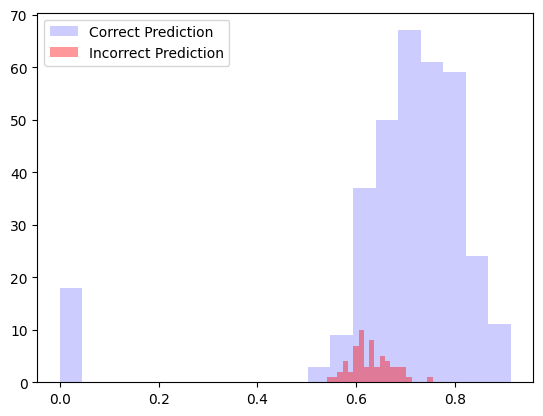

In [140]:
# Plot a value histogram for the known individual test

performace["correct_prediction"] = np.where(performace["ind"] == performace["prediction"], True, False)

mask = performace['correct_prediction'] == True
correct_df = performace[mask]
incorrect_df = performace[~mask]

# Plot the histograms

plt.hist(correct_df['confidence'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['confidence'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.1_Family_benchmark_histogram_knownPhotos.png")
plt.show()

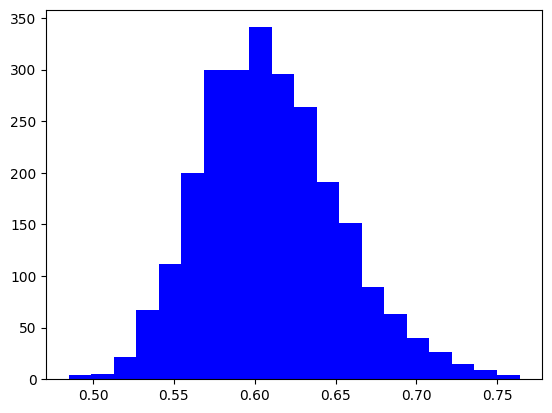

In [141]:
# Plot a value histogram for the unknown individual test
# Plot the histograms

plt.hist(performace_new_individuals['confidence'], color='blue', bins = 20)
plt.savefig("report_figures/01.1_Family_benchmark_histogram_newPhotos.png")
plt.show()

In [142]:
# Performance metrics without taking into account a treshold
metrics = performance_metrics(performace, "ind", "prediction", min_confidence = 0)

print("Performance metrics on known photos, without taking into account a treshold")
print(metrics)

print("\n\n")

# Performance metrics taking into account a treshold
metrics = performance_metrics(performace, "ind", "prediction", min_confidence = 0.8)

print(f"Performance metrics on known photos, taking into account a treshold : 0.8")
print(metrics)

Performance metrics on known photos, without taking into account a treshold
{'Accuracy': 0.8403141361256544, 'Precision': 0.8773622538020442, 'Recall': 0.8403141361256544, 'F1 Score': 0.8307472632079963, 'prediction_ignored': 4.5}



Performance metrics on known photos, taking into account a treshold : 0.8
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'prediction_ignored': 85.5}


Plot the Accuracy, F1 score and discarded photos with each treshold

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


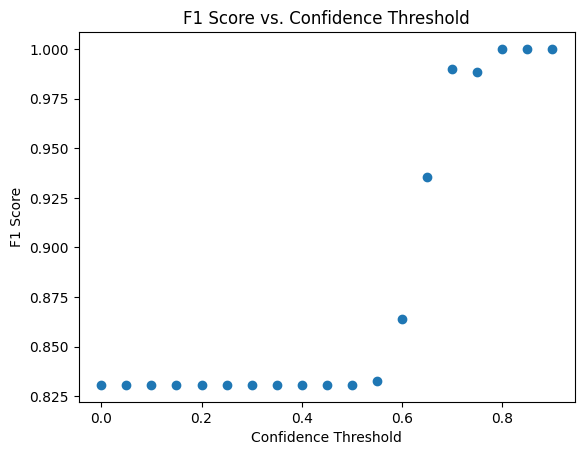

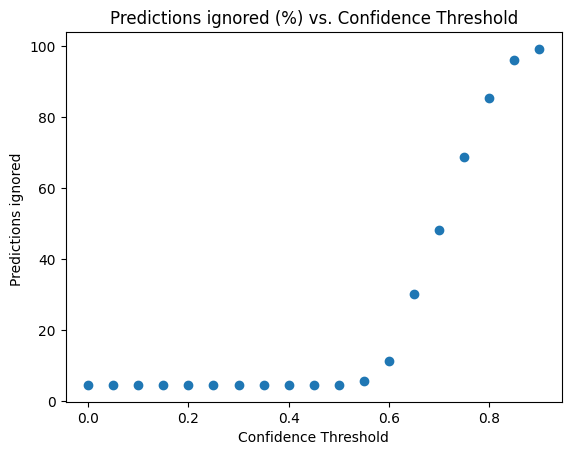

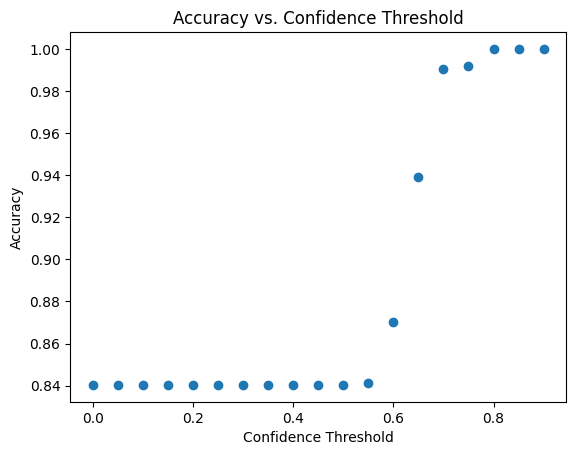

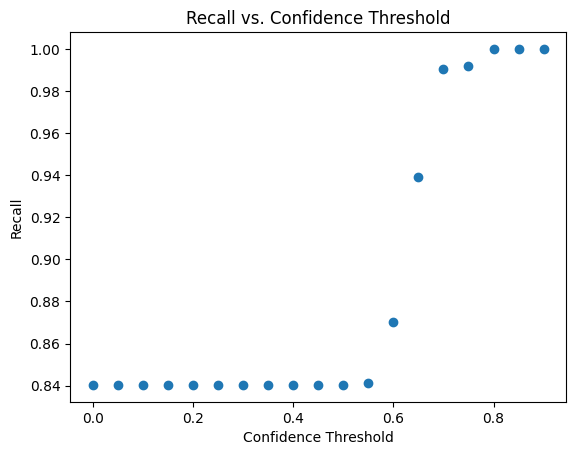

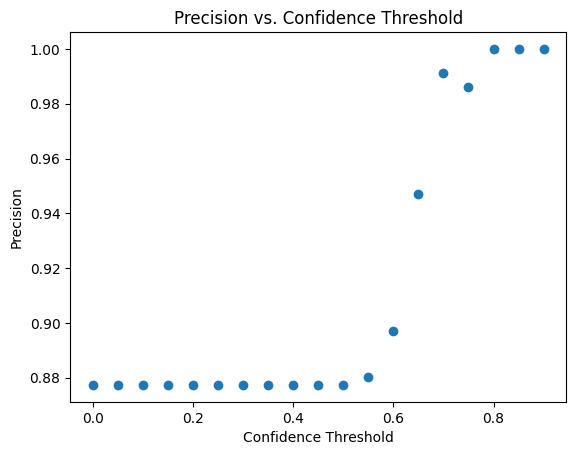

In [143]:
metrics_table = output_metrics_table(performace, min_conf = min(performace["confidence"]), max_conf = 1, step = 0.05)

# Filter out NaN values
metrics_table = metrics_table[~metrics_table["Accuracy"].isna()]

#Plot: Recall	F1 Score	Accuracy	prediction_ignored

# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table["Confidence Threshold"], metrics_table["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored ")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()

In [144]:
performace_new_individuals.to_csv("tables/01.1_Family_benchmark_performance_new_inviduals.csv")
performace.to_csv("tables/01.1_Family_benchmark_performance.csv")
metrics_table.to_csv("tables/01.1_Family_benchmark_performance_metrics.csv")

### Second Scenario:  Family of 4, Train using 5 photo

In [ ]:
performace_train_5, performace_new_individuals_train_5 = small_group_benchmark(metadata_subset, n_interations = 25, n_individuals = 4, n_photos_train = 5, n_photos_test_family = 5, n_photos_test_group = 100)

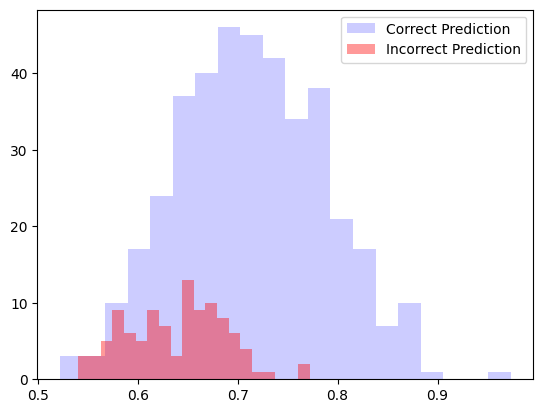

In [121]:
# Plot a value histogram for the known individual test

performace_train_5["correct_prediction"] = np.where(performace_train_5["ind"] == performace_train_5["prediction"], True, False)

mask = performace_train_5['correct_prediction'] == True
correct_df = performace_train_5[mask]
incorrect_df = performace_train_5[~mask]

# Plot the histograms

plt.hist(correct_df['confidence'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['confidence'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.2_Family_benchmark_histogram_knownPhotos.png")
plt.show()

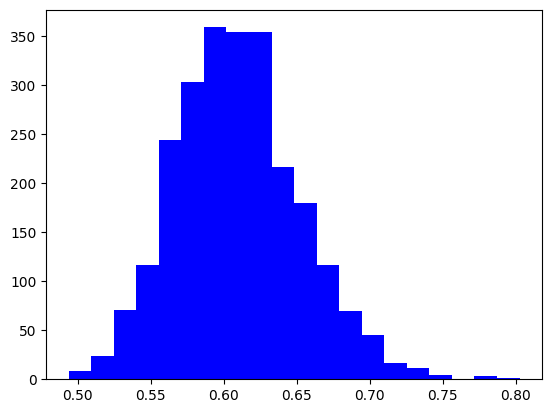

In [122]:
# Plot a value histogram for the unknown individual test
# Plot the histograms

plt.hist(performace_new_individuals_train_5['confidence'], color='blue', bins = 20)
plt.savefig("report_figures/01.2_Family_benchmark_histogram_newPhotos.png")
plt.show()

In [123]:
# Performance metrics without taking into account a treshold
metrics = performance_metrics(performace_train_5, "ind", "prediction", min_confidence = 0)

print("Performance metrics on known photos, without taking into account a treshold")
print(metrics)

print("\n\n")

# Performance metrics taking into account a treshold
metrics = performance_metrics(performace_train_5, "ind", "prediction", min_confidence = 0.8)

print(f"Performance metrics on known photos, taking into account a treshold : 0.8")
print(metrics)

print("\n\n")

# Performance metrics on new photos
metrics = performance_metrics(performace_new_individuals_train_5, "ind", "prediction", min_confidence = 0.8)

print(f"Performance metrics on new photos, taking into account a treshold : 0.8")
print(metrics)

Performance metrics on known photos, without taking into account a treshold
{'Accuracy': 0.792, 'Precision': 0.7998073593073594, 'Recall': 0.792, 'F1 Score': 0.7778447385947386, 'prediction_ignored': 0.0}



Performance metrics on known photos, taking into account a treshold : 0.8
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'prediction_ignored': 90.4}



Performance metrics on new photos, taking into account a treshold : 0.8
{'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'prediction_ignored': 99.96}


In [124]:
metrics_table_train_5 = output_metrics_table(performace_train_5, min_conf = min(performace_train_5["confidence"]), max_conf = 1, step = 0.05)
metrics_table_train_5.to_csv("tables/01.2_Family_benchmark_performance_metrics.csv")

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Plot the Accuracy, F1 score and discarded photos with each treshold

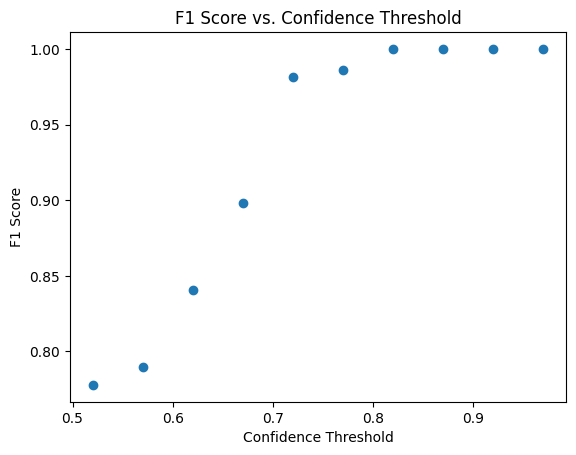

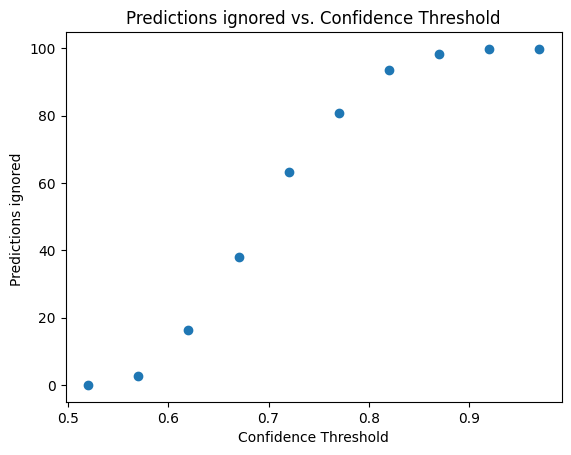

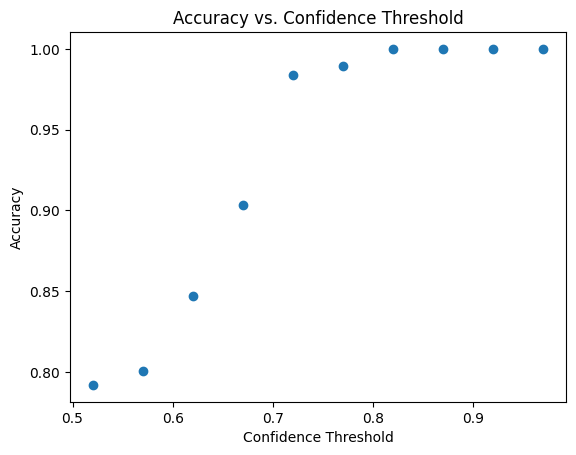

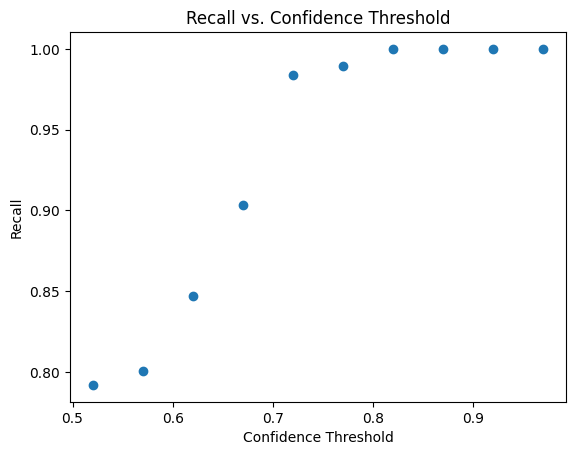

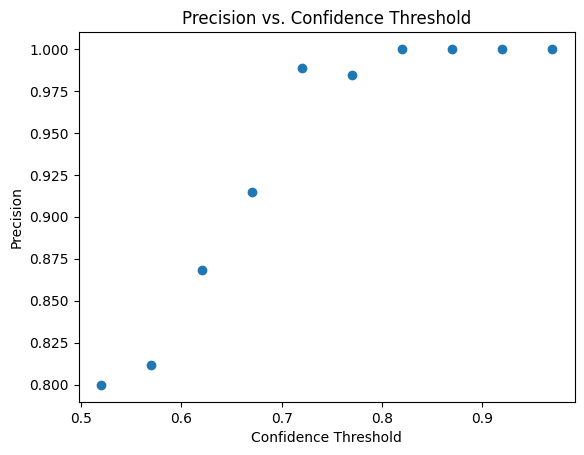

In [139]:
# Filter out NaN values
metrics_table_train_5  = metrics_table_train_5[~metrics_table_train_5["Accuracy"].isna()]

#Plot: Recall	F1 Score	Accuracy	prediction_ignored

# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table_train_5["Confidence Threshold"], metrics_table_train_5["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table_train_5["Confidence Threshold"], metrics_table_train_5["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored ")
plt.title("Predictions ignored vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table_train_5["Confidence Threshold"], metrics_table_train_5["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table_train_5["Confidence Threshold"], metrics_table_train_5["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table_train_5["Confidence Threshold"], metrics_table_train_5["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()

In [ ]:
performace_new_individuals.to_csv("tables/01.2_Family_benchmark_performance_new_inviduals.csv")
performace.to_csv("tables/01.2_Family_benchmark_performance.csv")

How many prediction are discarded on the new photos not seen by deepstack

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of e

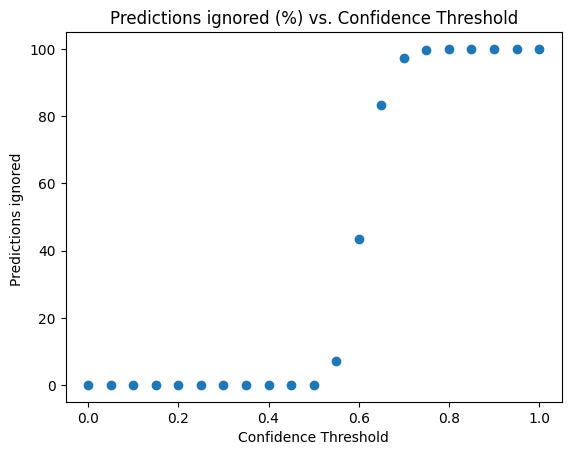

In [138]:
metrics_table_new_train_5 = output_metrics_table(performace_new_individuals_train_5, min_conf = 0, max_conf = 1, step = 0.05)

plt.scatter(metrics_table_new_train_5["Confidence Threshold"], metrics_table_new_train_5["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored ")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_newPredictionsignoredVSConfidance.png")
plt.show()


### Third Scenario:  Family of 4 Train using 15 photos

In [23]:
performace_train_15, performace_new_individuals_train_15 = small_group_benchmark(metadata_subset, n_interations = 25, n_individuals = 4, n_photos_train = 15, n_photos_test_family = 5, n_photos_test_group = 100)

Running iteration nº 0
Running iteration nº 5
{'success': False, 'error': 'no face detected', 'duration': 0}
Running iteration nº 10
Running iteration nº 15
Running iteration nº 20


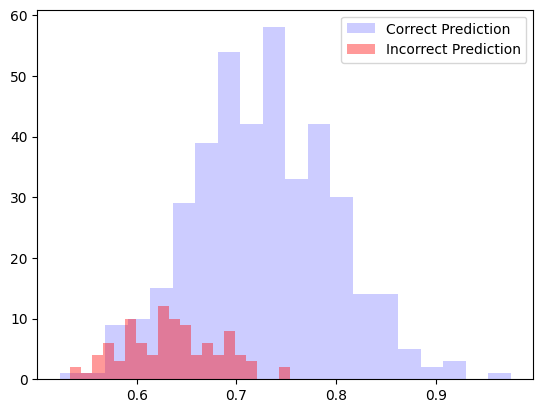

In [24]:
# Plot a value histogram for the known individual test

performace_train_15["correct_prediction"] = np.where(performace_train_15["ind"] == performace_train_15["prediction"], True, False)

mask = performace_train_15['correct_prediction'] == True
correct_df = performace_train_15[mask]
incorrect_df = performace_train_15[~mask]

# Plot the histograms

plt.hist(correct_df['confidence'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['confidence'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.3_Family_benchmark_histogram_knownPhotos.png")
plt.show()

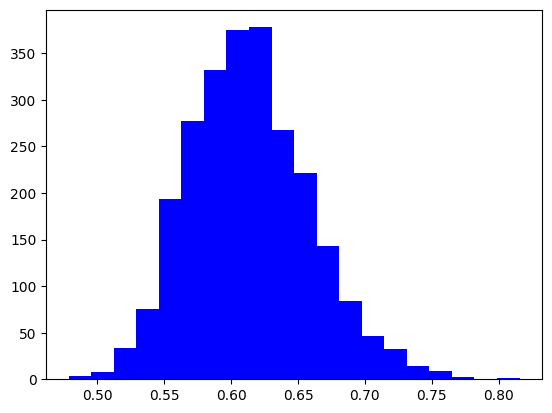

In [25]:
# Plot a value histogram for the unknown individual test
# Plot the histograms

plt.hist(performace_new_individuals_train_15['confidence'], color='blue', bins = 20)
plt.savefig("report_figures/01.3_Family_benchmark_histogram_newPhotos.png")
plt.show()

In [26]:
# Performance metrics without taking into account a treshold
metrics = performance_metrics(performace_train_15, "ind", "prediction", min_confidence = 0)

print("Performance metrics on known photos, without taking into account a treshold")
print(metrics)

print("\n\n")

# Performance metrics taking into account a treshold
metrics = performance_metrics(performace_train_15, "ind", "prediction", min_confidence = 0.8)

print(f"Performance metrics on known photos, taking into account a treshold : 0.8")
print(metrics)

print("\n\n")

# Performance metrics on new photos
metrics = performance_metrics(performace_new_individuals_train_15, "ind", "prediction", min_confidence = 0.8)

print(f"Performance metrics on new photos, taking into account a treshold : 0.8")
print(metrics)

Performance metrics on known photos, without taking into account a treshold
{'Accuracy': 0.804, 'Precision': 0.8363730158730158, 'Recall': 0.804, 'F1 Score': 0.7940577331165566}



436 / 500 rows were removed
Performance metrics on known photos, taking into account a treshold : 0.8
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}



2499 / 2500 rows were removed
Performance metrics on new photos, taking into account a treshold : 0.8
{'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0}


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plot the Accuracy, F1 score and discarded photos with each treshold

In [130]:
metrics_table_train_15 = output_metrics_table(performace_train_15, min_conf = min(performace_train_15["confidence"]), max_conf = 1, step = 0.05)
metrics_table_train_15.to_csv("tables/01.3_Family_benchmark_performance_metrics.csv")

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


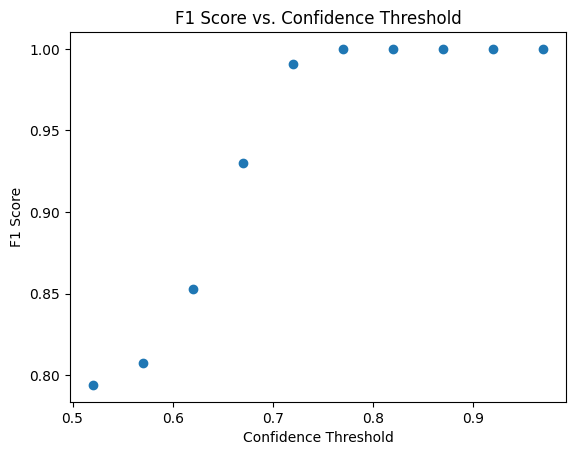

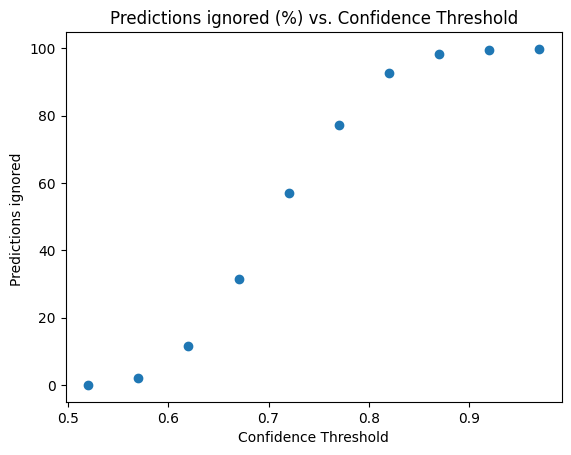

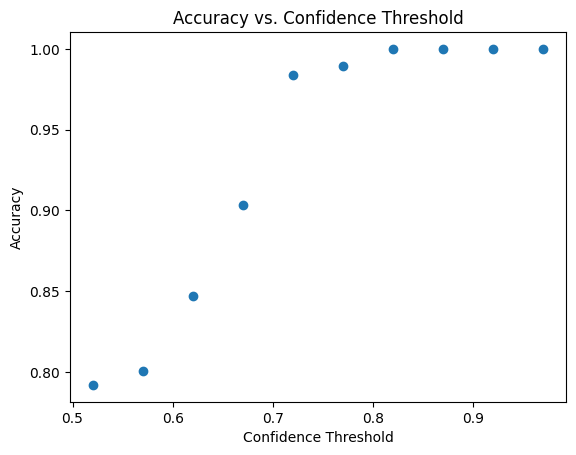

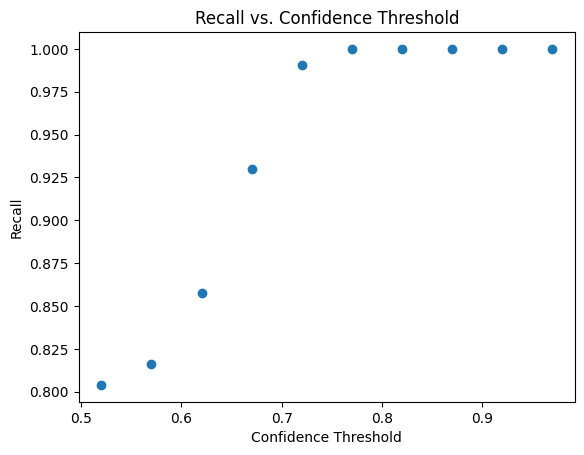

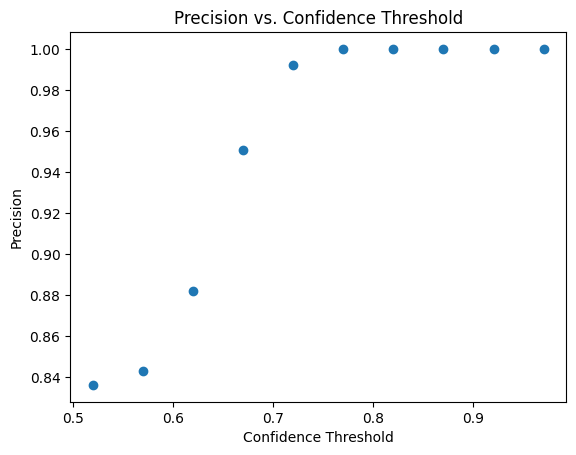

In [136]:
# Filter out NaN values
metrics_table_train_15  = metrics_table_train_15[~metrics_table_train_15["Accuracy"].isna()]

#Plot: Recall	F1 Score	Accuracy	prediction_ignored

# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table_train_15["Confidence Threshold"], metrics_table_train_15["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table_train_15["Confidence Threshold"], metrics_table_train_15["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored ")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table_train_15["Confidence Threshold"], metrics_table_train_5["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table_train_15["Confidence Threshold"], metrics_table_train_15["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table_train_15["Confidence Threshold"], metrics_table_train_15["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()

In [133]:
performace_new_individuals_train_15.to_csv("tables/01.3_Family_benchmark_performance_new_inviduals.csv")
performace_train_15.to_csv("tables/01.3_Family_benchmark_performance.csv")

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of e

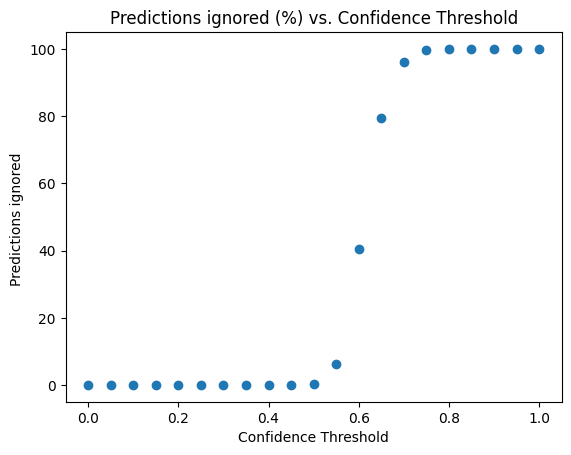

In [135]:
metrics_table_new_train_15 = output_metrics_table(performace_new_individuals_train_15, min_conf = 0, max_conf = 1, step = 0.05)

plt.scatter(metrics_table_new_train_15["Confidence Threshold"], metrics_table_new_train_15["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored ")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_new_PredictionsignoredVSConfidance.png")
plt.show()
